# Restricted Boltzmann Machines

### Energy-based model
Energy-based models associate a scalar energy to each configuration of the variables of interest. Low energy is more desirable. The probability distribution based on an energy function can be defined as follows
$$ \Pr(x) = \frac{\exp (-E(x))}{Z}\,,$$
where $Z = \sum_{x} \exp (-E(x))$ denotes the normalization factor or **partition function**. 

### Restricted Boltzmann Machine

Restricted Boltzmann Machine (RBM) has an efficient training algorithm. In order to increase the expressive power of the model, we do not observe the example $x$ fully, we also want to introduce some non-observed variables.  Consider an observed part $x$ and a hidden part $h$. We can then write:
$$\Pr(x) = \sum_h \frac{\exp (-E(x, h))}{Z} \,.$$

In RBM, the energy function is defined as
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows
$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$

We have an tractable expression for the conditional probabilities
$$
\Pr (h|x) = \prod_i \Pr (h_i | x)
$$

In [1]:
import os
print(os.environ['SHELL'])


/bin/bash


In [82]:
import matplotlib.pyplot as plt
from importlib import reload
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import rbm
reload(rbm)
from rbm import RBM
import libs
from libs import train, show_and_save

Make some configurations

In [48]:
batch_size = 64 # batch size
n_epochs = 12 # number of epochs
lr = 0.001 # learning rate
n_hid = 128 # number of neurons in the hidden layer
n_vis = 784 # input size
k = 1 # number of contrastive divergence steps during training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


Create a RBM model

In [64]:
# create a Restricted Boltzmann Machine
model = RBM(n_vis=n_vis, n_hid=n_hid, k=k).to(device)


Prepare the data set

In [50]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./output', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True if device == "cuda" else False,
)

Then train the model.

In [51]:
epoch_loss = train(model, train_loader, device, n_epochs=n_epochs, lr=lr)

plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Loss (n_hid={n_hid}, n_epochs={n_epochs}, lr={lr}, k={k})')
custom_path = f'rbm_{n_hid}_{n_epochs}_{lr}_{k}'
plt.savefig('plots/' + custom_path + '.png')
plt.close()

filepath = 'weights/'
filepath += custom_path + '.pt'
torch.save(model.state_dict(), filepath)

  8%|▊         | 1/12 [00:03<00:41,  3.77s/it]

Epoch 0	 Loss=442.6608


 17%|█▋        | 2/12 [00:07<00:38,  3.89s/it]

Epoch 1	 Loss=51.0703


 25%|██▌       | 3/12 [00:12<00:37,  4.15s/it]

Epoch 2	 Loss=19.9587


 33%|███▎      | 4/12 [00:16<00:33,  4.19s/it]

Epoch 3	 Loss=11.5662


 42%|████▏     | 5/12 [00:21<00:30,  4.36s/it]

Epoch 4	 Loss=6.4681


 50%|█████     | 6/12 [00:25<00:26,  4.45s/it]

Epoch 5	 Loss=3.4609


 58%|█████▊    | 7/12 [00:30<00:22,  4.53s/it]

Epoch 6	 Loss=1.7291


 67%|██████▋   | 8/12 [00:34<00:17,  4.36s/it]

Epoch 7	 Loss=0.6214


 75%|███████▌  | 9/12 [00:39<00:13,  4.46s/it]

Epoch 8	 Loss=-0.1287


 83%|████████▎ | 10/12 [00:43<00:09,  4.57s/it]

Epoch 9	 Loss=-0.6995


 92%|█████████▏| 11/12 [00:48<00:04,  4.44s/it]

Epoch 10	 Loss=-1.1002


100%|██████████| 12/12 [00:52<00:00,  4.40s/it]

Epoch 11	 Loss=-1.3466


Now, we can do inpainting using the saved weights. We can treat this task as conditioned generation. At every step of gibbs sampling in the CD-k algo, we can convert the observed pixels back to their true values.

In [83]:
batch_size = 64 # batch size
n_hid = 128 # number of neurons in the hidden layer
n_vis = 784 # input size
k = 1000 # number of contrastive divergence steps during inference

# this will correspond to the test set where the only the top half of the image
# is observed and the task is to predict the bottom half of the image
# since this is grayscale, we will be using accuracy as the metric

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./output', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size
)

model = RBM(n_vis=n_vis, n_hid=n_hid, k=k)
model.load_state_dict(torch.load(filepath))
model.to(device)

RBM()

In [87]:
print(len(test_loader.dataset))

10000


Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 100


0it [00:00, ?it/s]

2664 6400
k:  100
intermediate length  11


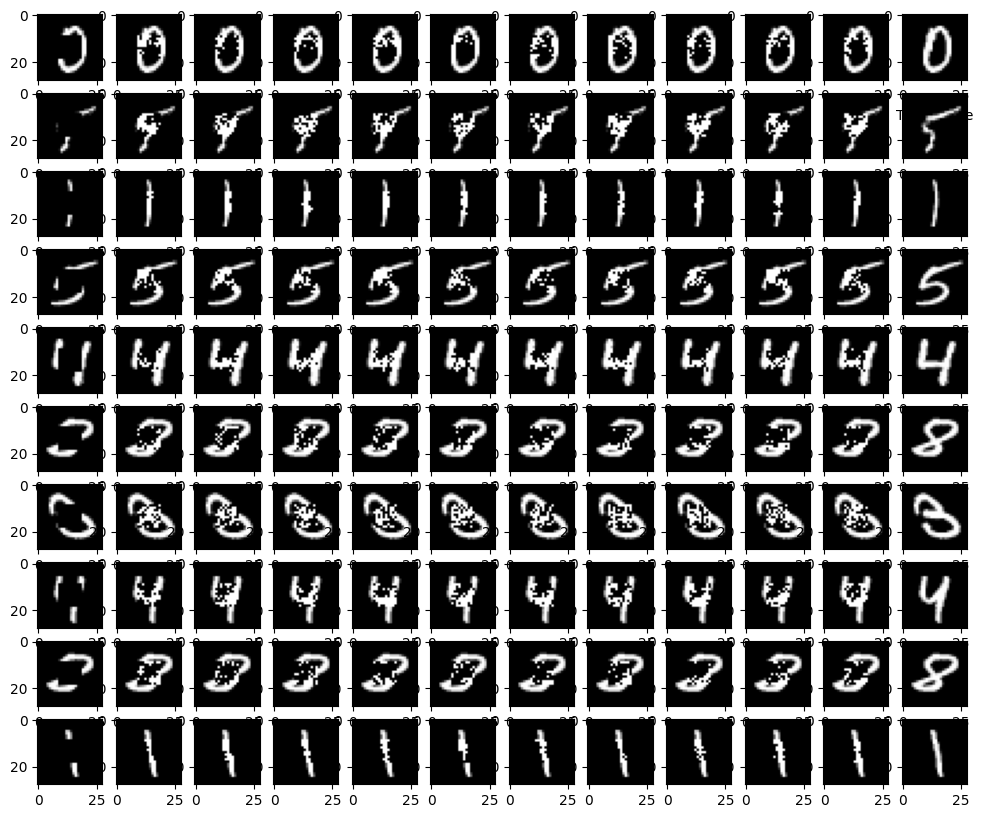

0it [00:07, ?it/s]


correct: 2664 total: 6400
Final Accuracy: 41.62%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 100


0it [00:00, ?it/s]

2673 6400
k:  100
intermediate length  11


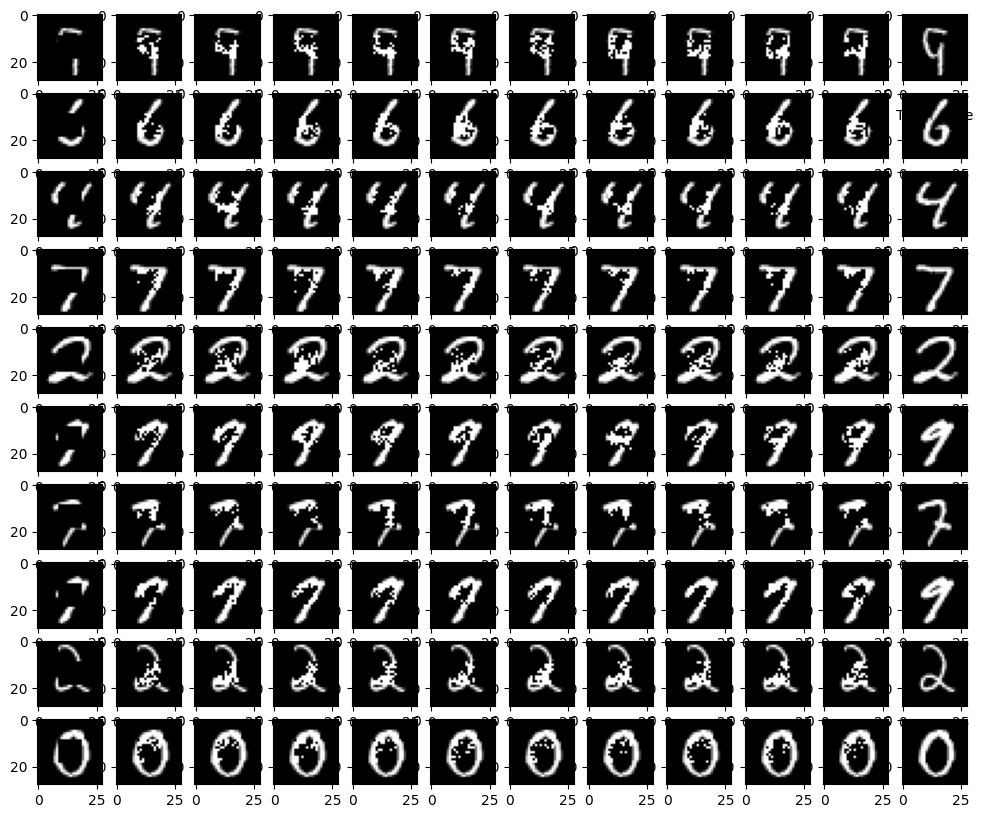

0it [00:07, ?it/s]


correct: 2673 total: 6400
Final Accuracy: 41.77%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 100


0it [00:00, ?it/s]

2664 6400
k:  100
intermediate length  11


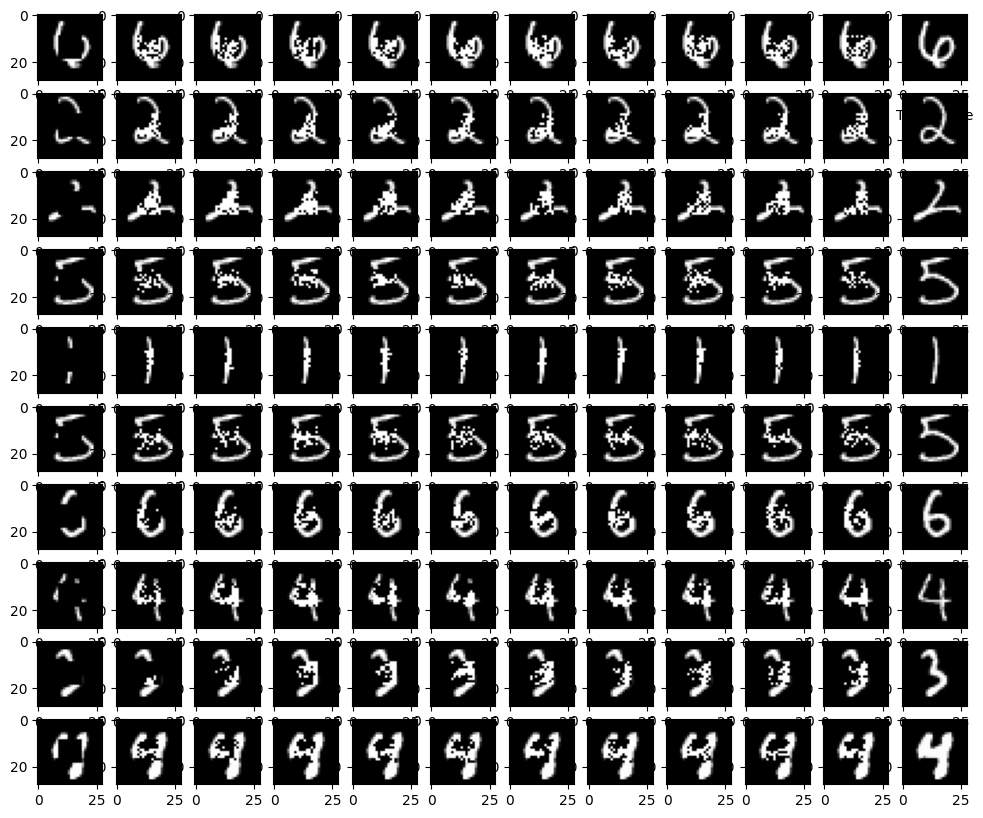

0it [00:07, ?it/s]


correct: 2664 total: 6400
Final Accuracy: 41.62%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 100


0it [00:00, ?it/s]

2642 6400
k:  100
intermediate length  11


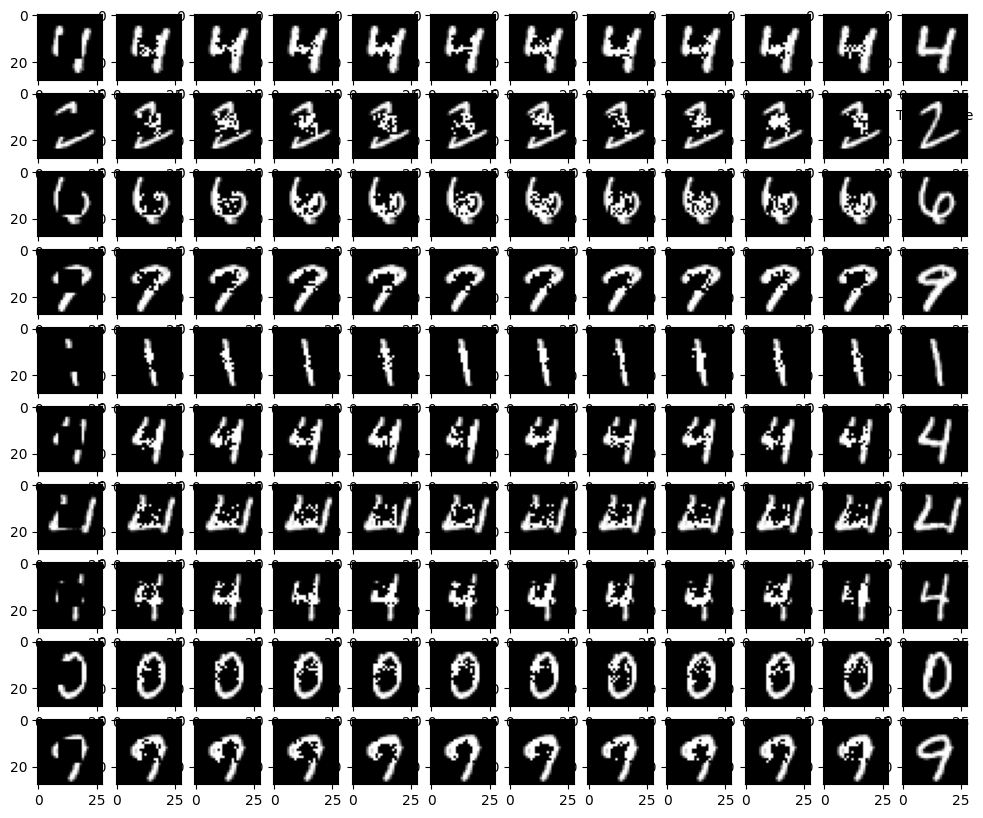

0it [00:07, ?it/s]


correct: 2642 total: 6400
Final Accuracy: 41.28%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 100


0it [00:00, ?it/s]

2648 6400
k:  100
intermediate length  11


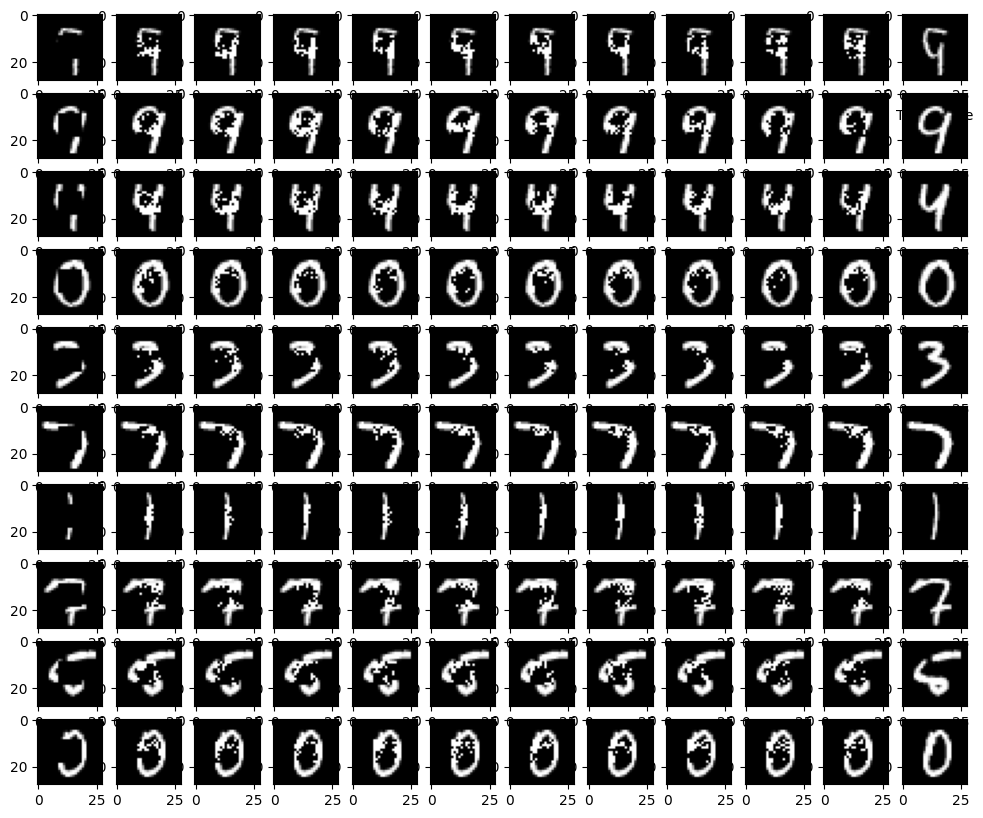

0it [00:07, ?it/s]


correct: 2648 total: 6400
Final Accuracy: 41.38%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 1000


0it [00:00, ?it/s]

2648 6400
k:  1000
intermediate length  11


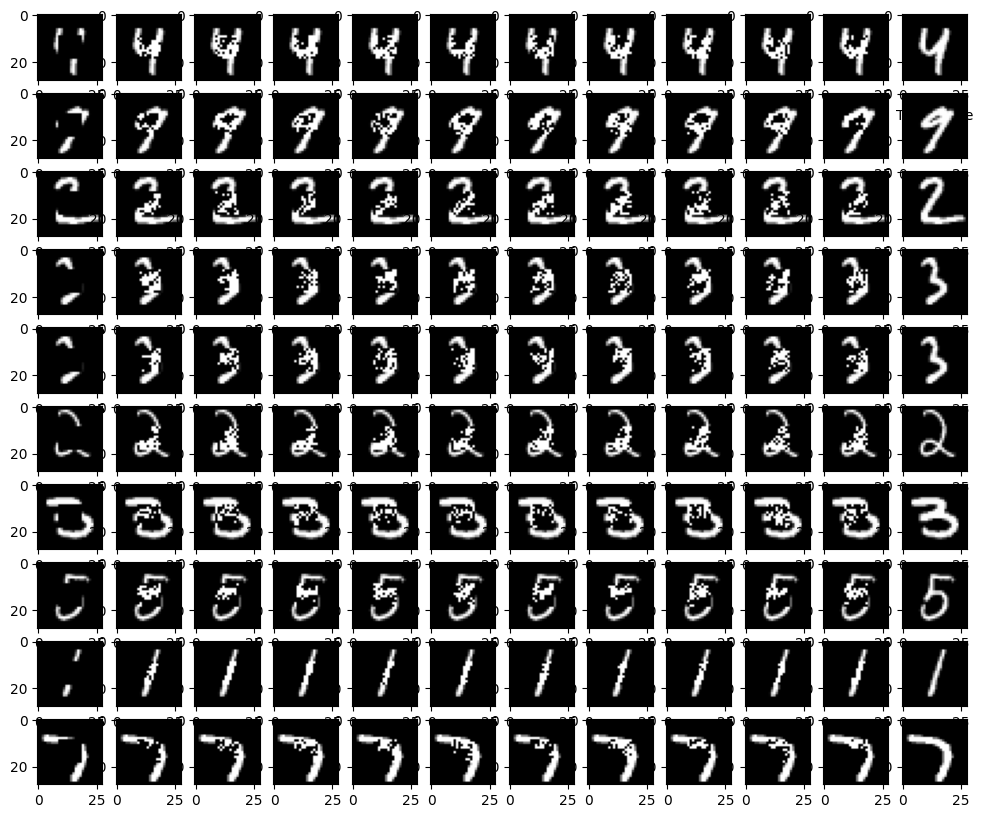

0it [00:08, ?it/s]


correct: 2648 total: 6400
Final Accuracy: 41.38%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 1000


0it [00:00, ?it/s]

2638 6400
k:  1000
intermediate length  11


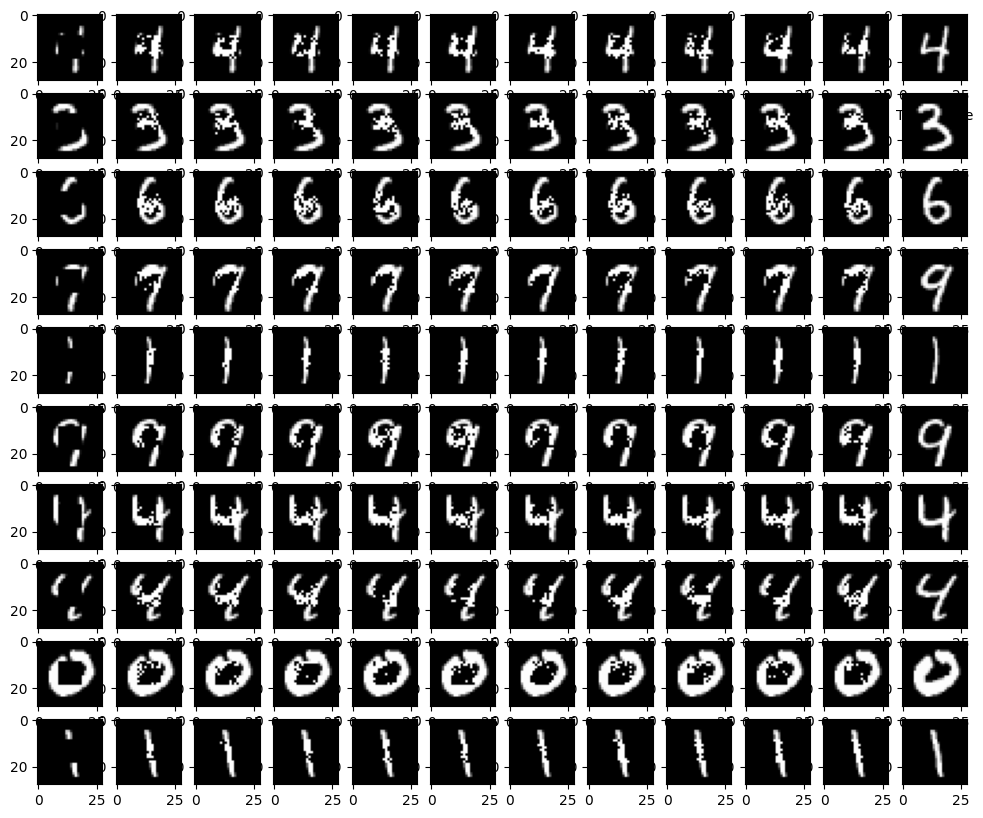

0it [00:08, ?it/s]


correct: 2638 total: 6400
Final Accuracy: 41.22%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 1000


0it [00:00, ?it/s]

2690 6400
k:  1000
intermediate length  11


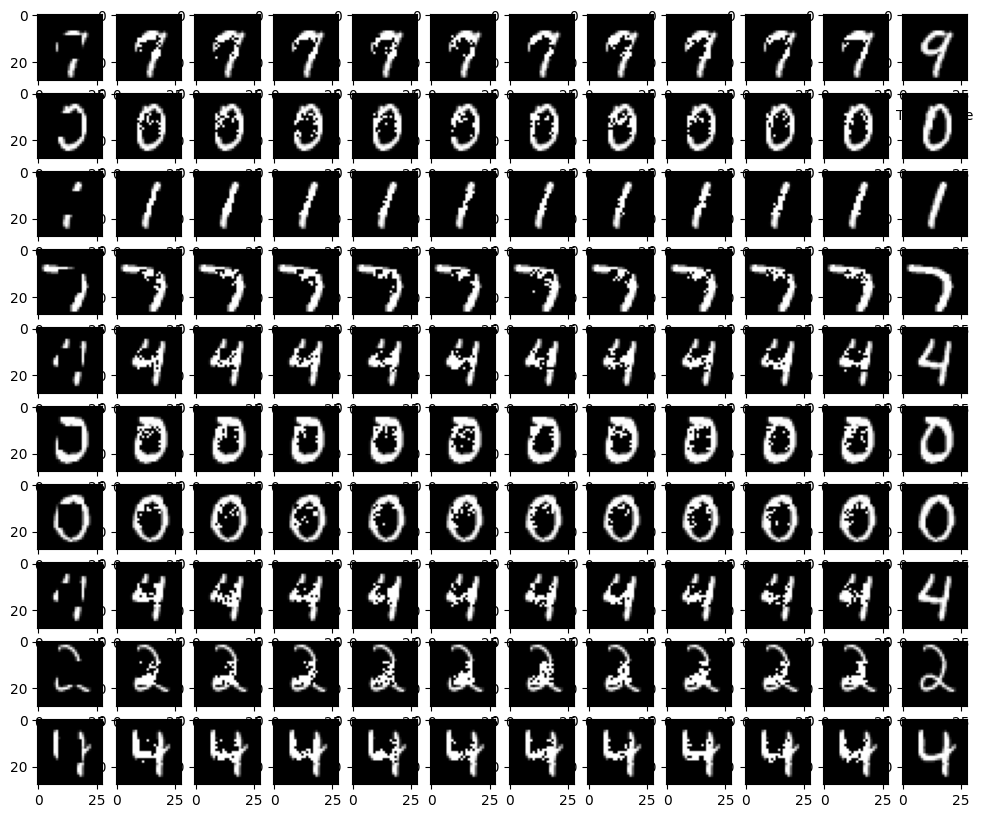

0it [00:08, ?it/s]


correct: 2690 total: 6400
Final Accuracy: 42.03%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 1000


0it [00:00, ?it/s]

2723 6400
k:  1000
intermediate length  11


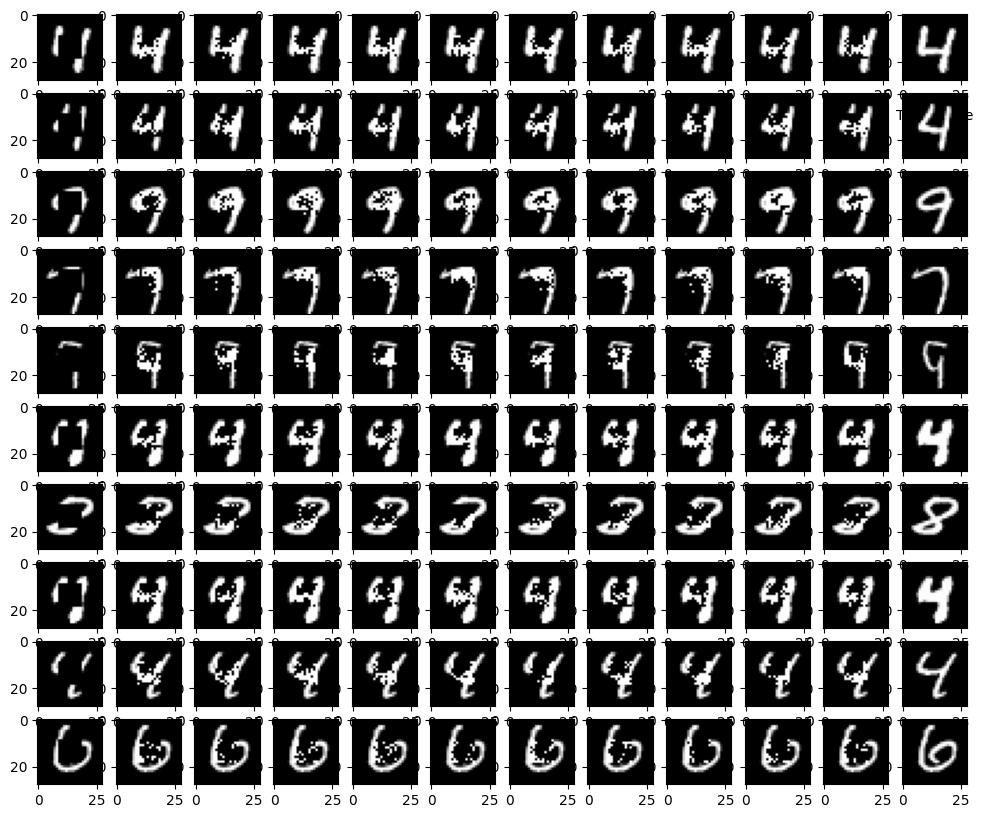

0it [00:08, ?it/s]


correct: 2723 total: 6400
Final Accuracy: 42.55%
Testing the RBM model for inpainting...
Inpainting Technique: zero_center_crop ; k: 1000


0it [00:00, ?it/s]

2645 6400
k:  1000
intermediate length  11


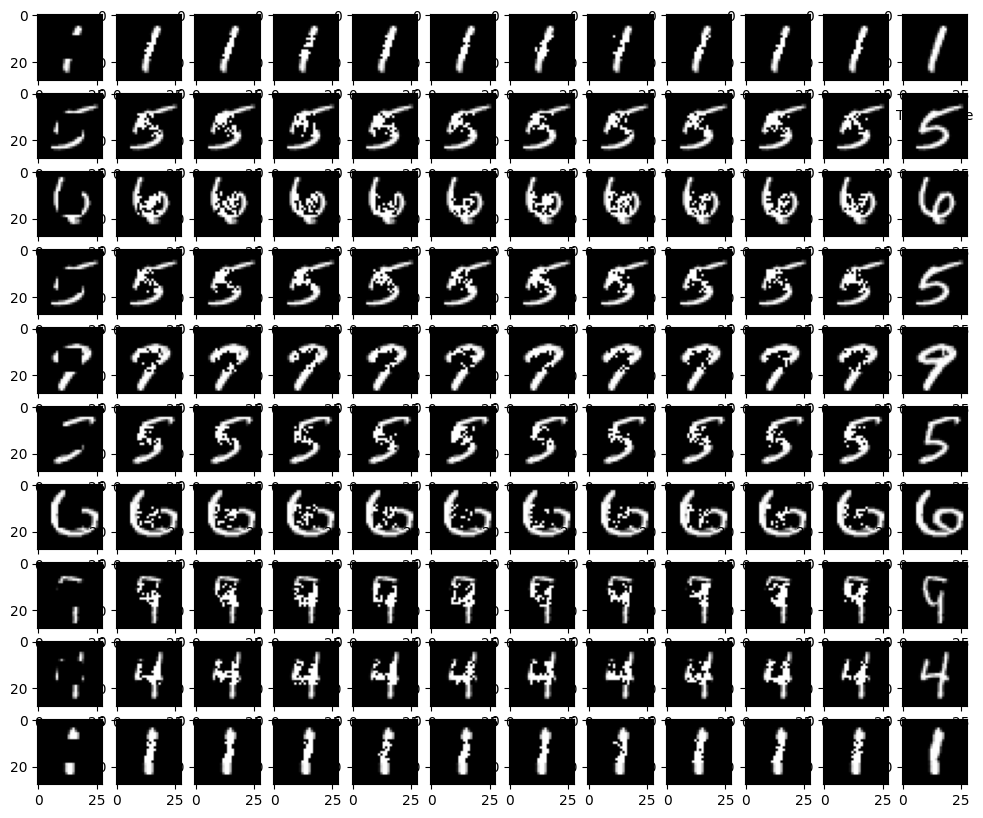

0it [00:08, ?it/s]

correct: 2645 total: 6400
Final Accuracy: 41.33%


In [92]:
# can play around with this k during test time
reload(libs)

# here the plot is logged every 0.1 * k many iterations so basically every 10th percentile
# the very left column in the plot corresponds to the input image
# the very right column in the plot corresponds to the true image
k = 100
for _ in range(5):
    acc = libs.test_for_inpaint(model, test_loader, device, inpainting_technique='zero_center_crop',k=k, plot=True)
k = 1000
for _ in range(5):
    acc = libs.test_for_inpaint(model, test_loader, device, inpainting_technique='zero_center_crop',k=k, plot=True)

In [ ]:
reload(libs)
acc = libs.test_for_inpaint(model, test_loader, device, random_values='zero_top_half',k=k)
acc = libs.test_for_inpaint(model, test_loader, device, random_values='random_top_half',k=k)

In [ ]:
reload(libs)
# print('1', torch.cuda.memory_summary())
torch.cuda.empty_cache()
# print('2', torch.cuda.memory_summary())
acc = libs.test_for_inpaint(model, test_loader, device, random_values=True,k=50000, plot=True)
acc = libs.test_for_inpaint(model, test_loader, device, random_values=False,k=1000, plot=True)

Ignore the rest of the stuff below for now :)

In [ ]:
images = next(iter(train_loader))[0]
v, v_gibbs = model(images.view(-1, 784))

In [ ]:
# show the real images
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'output/real')

In [ ]:
# show the generated images
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'output/fake')

How one image is factorized through the hidden variables

In [ ]:
n_sample = 4
kth = 18
d = images[kth:kth+1]

V = torch.sigmoid(F.linear(d.view(1, -1), model.W, model.h))
v, o = torch.sort(V.view(-1))

fig, ax = plt.subplots(1, n_sample + 1, figsize=(3*(1 + n_sample),3))
ax[0].imshow(d.view(28, 28).numpy(), cmap='gray')
ax[0].set_title('Original image')

for k, i in enumerate(o[-n_sample:].numpy()):
    f = model.W[i].view(28, 28).data.numpy()
    ax[k + 1].imshow(f, cmap='gray')
    ax[k + 1].set_title('p=%.2f'% V[0][i].item())
    
plt.savefig('output/factor.png', dpi=200)